# Calculate and plot Ensembles: project Erica

> Marcos Duarte  
> [Laboratory of Biomechanics and Motor Control](http://demotu.org/)  
> Federal University of ABC, Brazil

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span><ul class="toc-item"><li><span><a href="#Some-color-and-plot-configuration" data-toc-modified-id="Some-color-and-plot-configuration-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Some color and plot configuration</a></span></li></ul></li><li><span><a href="#Helping-functions" data-toc-modified-id="Helping-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Helping functions</a></span></li><li><span><a href="#Load-features" data-toc-modified-id="Load-features-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load features</a></span></li><li><span><a href="#Create-DataArray-for-conditions-and-plot" data-toc-modified-id="Create-DataArray-for-conditions-and-plot-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create DataArray for conditions and plot</a></span></li></ul></div>

## Python setup

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
import glob
import xarray as xr
from pyversions import versions
from tqdm.notebook import tqdm
sys.path.insert(1, r'./../../BMC/functions')
import read_c3d_xr
xr.set_options(keep_attrs=True)

versions();

Linux 5.4.0-48-generic 64-bit #52-Ubuntu SMP Thu Sep 10 10:58:49 UTC 2020
CPython 3.8.6 packaged by conda-forge (default, Oct  7 2020, 19:08:05) [GCC 7.5.0]
Oct 13 2020, 22:23:06

Module           Version
ipython           7.18.1
jupyterlab         2.2.8
matplotlib         3.3.2
notebook           6.1.4
numpy             1.19.2
pandas             1.1.3
pyversions         0.0.3
read_c3d_xr        0.0.1
scipy              1.5.2
seaborn           0.11.0
xarray            0.16.1


### Some color and plot configuration

In [2]:
sns.set_context('notebook', font_scale=1.05, rc={"lines.linewidth": 1.5})
sns.set_style("darkgrid")  # {darkgrid, whitegrid, dark, white, ticks}
# print colors
cr = "\033[1;31m"  # red
cb = "\033[1;34m"  # blue
cg = "\033[1;32m"  # green
rs = "\033[0m"     # reset
# plot colors
# https://matplotlib.org/3.1.0/gallery/color/named_colors.html
color1 = 'royalblue'
color2 = 'darkblue'

## Helping functions

In [3]:
def processa(fname, prm, var='GRF', methodt='interp', cycle='stride'):
    """
    """
    if var=='Oxford2':
        data = read_c3d_xr.read_c3d(fname, var=var[:-1], prm=prm)
        data.name = var
    else:
        data = read_c3d_xr.read_c3d(fname, var=var, prm=prm)
    events = read_c3d_xr.find_ev_GRFcycle(data)
    if cycle != 'stride' and events['1'][1][1:] == 'FS':
        side = events['1'][1][0]
        events['1'] = [events[side+'FO'][0], side+'FO']
        events[side+'FS'] = [events[side+'FS'][:1]]
    side = data.Time.attrs['side']
    data = read_c3d_xr.trimmer(data, evs=events, trim=1)
    if var == 'GRF':
        data = read_c3d_xr.normala(data, method='BW', mass=prm['mass'])
    elif var in ['Moment', 'Power']:
        data = read_c3d_xr.normala(data, method='BM', mass=prm['mass'], LL=prm['LL'][side])
    data = read_c3d_xr.normalt(data, method=methodt, step=1)
    if var == 'GRF':
        data.values[:, 0, 0] = data.values[:, 0, 0] - data.values[-1, 0, 0]
        if np.nanmean(data.values[:, 0, 0]) > 0:
            data.values[:, 0, 0] = -data.values[:, 0, 0]      
    elif var in ['Angle', 'Moment']:
        var2 = [side + joint for joint in ['Hip', 'Knee', 'Ankle']]
        data = data.sel(Var=var2)
    elif var == 'Power':
        var2 = [side + joint for joint in ['Hip', 'Knee', 'Ankle']]
        data = data.sel(Var=var2)
    elif var == 'Oxford':
        var2 = [side + joint for joint in ['HFTBA', 'FFHFA', 'FFTBA', 'HXFFA']]
        data = data.sel(Var=var2)
        data.loc[dict(Var=side+'HXFFA', Axis='AP')] = data.sel(Var=side+'HXFFA', Axis='AP').values /\
                                                      prm['FL'][side] * 100
    elif var == 'Oxford2':
        var2 = [side + joint for joint in ['HXFFA', 'FFHFA', 'HFTBA']]
        data = data.sel(Var=var2)

    return data


def create_da(features, cycle='stride', variable='GRF'):
    """X dimensions [time, var, axis, trial, subject, assessment, group]
    """
    ft = features.copy(deep=True)
    # array with dimensions [time, var, axis, trial, subject, assessment, group]
    var = {'GRF': 1, 'Angle': 3, 'Moment': 3, 'Power': 3, 'Oxford': 4, 'Oxford2': 3}
    X = np.full((101, var[variable], 3, features['T'].max()+1, features['S'].max()+1,
                 features['A'].max()+1, features['G'].max()+1), np.nan)
    print('Creating DataArray for variable "{}" cycle "{}"'.format(variable, cycle))
    print('Dimensions [time, var, axis, trial, subject, assessment, group]:')
    print(X.shape)
    with tqdm(total=features.shape[0]) as pbar:
        for (i, fname, g, a, s, t) in features[['Filename', 'G', 'A', 'S', 'T']].itertuples(name=None):
            pbar.update()
            filename = os.path.join(path2, fname + '.c3d')
            prm = read_c3d_xr.get_parameters(filename)
            data = processa(filename, prm, var=variable, cycle=cycle)
            if cycle == 'stride' and features.loc[i, 'Cycle'] == 'stride':
                X[:, :, :, t, s, a, g] = data.values
            elif cycle == 'stance':
                X[:, :, :, t, s, a, g] = data.values    
    
    coords = {}
    coords['Time'] = data.Time.values
    if data.name in ['Angle', 'Moment', 'Power', 'Oxford', 'Oxford2']:
        coords['Var'] = [x[1:] for x in data.Var.values] 
    else:
        coords['Var'] = data.Var.values
    coords['Axis'] = data.Axis.values
    coords['Trial'] = range(X.shape[3])
    coords['Subject'] = ft.drop_duplicates('S')['Subject'].values
    coords['Assessment'] = ft.drop_duplicates('A')['Assessment'].values
    coords['Group'] = ft.drop_duplicates('G')['Group'].values    
    dims = ('Time', 'Var', 'Axis', 'Trial', 'Subject', 'Assessment', 'Group')
    da = xr.DataArray(data=X, dims=dims, coords=coords, name=data.name)
    da.attrs['units'] = data.attrs['units']
    da.Time.attrs['units'] = data.Time.attrs['units']
    return da     


def processa_plot(features, cycle='stride', variable='GRF'):
    """
    """
    da = create_da(features, cycle=cycle, variable=variable)
    x = similarity(da, dim='Trial', dim2='Time', central=np.nanquantile, normalize=1,
                   threshold=4, min_trials=5, q=.5)
    var = list(x.Var.values)
    g, footoff = plot(x, features, var, 'T00', 1, cycle=cycle, color=color1)
    g, footoff = plot(x, features, var, 'T08', 1, cycle=cycle, color=color2, g=g, FO_=footoff)
    g, footoff = plot(x, features, var, 'T00', 2, cycle=cycle, color=color1)
    g, footoff = plot(x, features, var, 'T08', 2, cycle=cycle, color=color2, g=g, FO_=footoff)   


def MSE(x, dim='Trial', dim2='Time', central=np.nanquantile, normalize=1,
        **kwargs):
    """Mean Squared Error of `x` w.r.t. `central` across `dim` over `dim2`.
    """
    import warnings
    warnings.filterwarnings('ignore', message=r'All-NaN slice encountered')
    
    mse = ((x - x.reduce(central, **kwargs, dim=dim))**2).reduce(np.nanmean, dim=dim2)
    if normalize == 1:  # normalize by the total MSE
        mse = mse/mse.reduce(np.nansum, dim=dim)
    elif normalize == 2:  # normalize by the data variance
        mse = mse/x.reduce(np.nanstd, dim=dim2)**2

    return mse


def similarity(da, dim='Trial', dim2='Time', central=np.nanquantile, normalize=1,
               threshold=4, min_trials=5, recursive=True, **kwargs):
    """
    """
    # TODO: replace loops with iteraction over dict
    # https://stackoverflow.com/questions/31686899/how-to-iterate-over-a-dynamic-object
    x = da.copy(deep=True)
    #coords = [coord for coord in x.coords.keys() if coord not in [dim, dim2]]
    print(cb, end='')
    print('Number of trials, outlier trial, MSE, Variable, Axis, Subject, Assessment, Group')
    print(rs, end='')
    for g in x['Group'].values:
        for a in x['Assessment'].values:
            for s in x['Subject'].values:
                for ax in x['Axis'].values:
                    for v in x['Var'].values:
                        mse = MSE(x.sel(Group=g, Assessment=a, Subject=s, Axis=ax, Var=v),
                                  dim=dim, dim2=dim2, central=central, normalize=normalize,
                                  **kwargs)
                        if not np.all(np.isnan(mse)):
                            mse = mse.sortby(mse, ascending=True)
                            n = np.count_nonzero(~np.isnan(mse.values))
                            while n > min_trials and mse.values[n-1] > threshold/n:
                                #print(n, mse['Trial'].values[n-1], mse.values[n-1], v, ax, s, a, g)
                                x.loc[dict(Group=g, Assessment=a, Subject=s, Axis=ax,
                                           Var=v, Trial=mse['Trial'].values[n-1])] = np.nan
                                mse = MSE(x.sel(Group=g, Assessment=a, Subject=s, Axis=ax, Var=v),
                                          dim=dim, dim2=dim2, central=central, normalize=normalize,
                                          **kwargs)
                                if not np.all(np.isnan(mse)):
                                    mse = mse.sortby(mse, ascending=True)
                                    n = np.count_nonzero(~np.isnan(mse.values))
                                    if n <= min_trials or mse.values[n-1] <= threshold/n:
                                        print(cr, end='')
                                        print(n, mse['Trial'].values[n-1],
                                              mse.values[n-1], v, ax, s, a, g)
                                        print(rs, end='')
                                else:
                                    pass
                                if not recursive:
                                    break
                            
    return x


def plot(da, features, var, assessment, group, mean=True, cycle='stride',
         color='b', g=None, FO_=None):
    """
    """
    ft = features.copy(deep=True)
    subject = ft[(ft['Group']==group) &
                 (ft['Assessment']==assessment)].drop_duplicates('S')['Subject'].values
    axis = 'VT' if da.name == 'Power' else 'ML'
    N = da.sel(Var=var[0], Axis=axis, Subject=subject, Assessment=assessment,
               Group=group).sum(dim='Time', skipna=False).squeeze()
    NT = N.count().values
    NS = N.sum(dim='Trial', skipna=True).squeeze().count().values 
    print('{} subjects'.format(NS))
    print('{} trials'.format(NT))

    if cycle == 'stride':
        ft['FO'] = ft[ft['Cycle']=='stride']['Stance Time']/ft[ft['Cycle']=='stride']['Stride Time']*100
        ft[ft['FO']>100] = np.nan
        FO = ft[(ft['Group']==group) & (ft['Assessment']==assessment)
                ][['Subject', 'FO']].groupby('Subject').agg(np.nanmedian).agg(['mean', 'std']).values
        FO[1][0] = FO[1][0]/np.sqrt(NS)
        footoff = FO[0][0]
    else:
        footoff = None

    if da.name == 'Power':
        axes = ['VT']
        row='Axis'
        col='Var'
    elif da.name == 'Oxford2':
        axes = ['ML']
        row='Axis'
        col='Var'
    else:
        axes = da.Axis.values
        row='Var'
        col='Axis'

    damed = da.sel(Var=var, Subject=subject, Assessment=assessment,
                   Group=group).reduce(np.nanquantile, q=.5, dim='Trial')
    damean = damed.sel(Var=var, Subject=subject).reduce(np.nanmean, dim='Subject')
    #ci = stats.t.ppf((1+95/100)/2, NS-1)/np.sqrt(NS)
    dastd = damed.sel(Var=var, Subject=subject).reduce(np.nanstd, ddof=1, dim='Subject')/np.sqrt(NS)
    if da.name in ['GRF', 'Power', 'Oxford2']:
        size = 3.6; aspect = 1.1
    elif da.name == 'Oxford':
        size = 2.9; aspect = 1.30
    else:
        size = 3; aspect = 1.25
    
    if g is None:
        g = damean.sel(Axis=axes).plot.line(x='Time', row=row, col=col, sharey=False,
                                            size=size, aspect=aspect, color=color,
                                            alpha=.8, lw=2, label=assessment)
        axs = np.atleast_2d(g.axes)
    else:
        axs = np.atleast_2d(g.axes)
        variables = da['Var'].values
        for r in range(axs.shape[0]):
            for c in range(axs.shape[1]):
                if da.name in ['Power', 'Oxford2']:
                    axs[r, c].plot(damean['Time'], damean.sel(Axis=axes).isel(Var=c, Axis=r),
                                   color=color, alpha=.8, lw=2, label=assessment)
                    axs[r, c].set_title(variables[c])
                else:
                    axs[r, c].plot(damean['Time'], damean.sel(Axis=axes).isel(Var=r, Axis=c),
                                   color=color, alpha=.8, lw=2, label=assessment)
                if r==0 and c==0:
                    loc = 'upper left' if cycle == 'stride' else 'upper center'
                    axs[r, c].legend(title='Assessment', frameon=False, loc=loc)  

                axs[r, c].set_xlim(0, 100)
                if (da.name=='Oxford' and r==3 and c==1):
                    axs[r, c].set_ylabel('Arch Height Length [%FL]')
                else:
                    axs[r, c].axhline(y=0, c='k', lw=1)
                if c == 0:
                    if da.name == 'Oxford':
                        axs[r, c].set_ylabel('{} Angle [{}]'.format(variables[r],
                                                                    da.attrs['units']))
                    elif da.name == 'Oxford2':
                        axs[r, c].set_ylabel('Angle [{}]'.format(da.attrs['units']))
                    elif da.name not in ['GRF', 'Power']:
                        axs[r, c].set_ylabel('{} {} [{}]'.format(variables[r], da.name,
                                                                 da.attrs['units']))
                    elif da.name not in ['GRF', 'Power']:
                        axs[r, c].set_ylabel('{} {} [{}]'.format(variables[r], da.name,
                                                                 da.attrs['units']))
                if (da.name=='Oxford' and r==3 and c==2):
                    axs[r, c].set_ylabel('FTA Angle [{}]'.format(da.attrs['units']))
                ant = [ch for ch in axs[r, c].get_children() if isinstance(ch, plt.Annotation)]
                if len(ant):
                    ant[0].remove()
                if r == 0:
                    axs[r, c].text(x=0, y=1.03, s='FS', fontsize=12, horizontalalignment='center',
                                   transform=axs[r, c].transAxes)
                    FSFO = 'FS' if cycle == 'stride' else 'FO'
                    axs[r, c].text(x=1, y=1.03, s=FSFO, fontsize=12, horizontalalignment='center',
                                   transform=axs[r, c].transAxes)   
                if cycle == 'stride':
                    if FO_ is not None and r == 0:
                        x = (FO_ + FO[0][0])/2/100 + np.max([3*FO[1][0]/100, .01])
                        axs[r, c].text(x=x, y=.92, s='FO', fontsize=12, horizontalalignment='left',
                                       transform=axs[r, c].transAxes)
                    
    for r in range(axs.shape[0]):
        for c in range(axs.shape[1]):   
            if da.name in ['Power', 'Oxford2']:
                axs[r, c].fill_between(da.Time, damean.sel(Axis=axes).isel(Var=c, Axis=r).squeeze()+
                                       dastd.sel(Axis=axes).isel(Var=c, Axis=r).squeeze(),
                                       damean.sel(Axis=axes).isel(Var=c, Axis=r).squeeze()-
                                       dastd.sel(Axis=axes).isel(Var=c, Axis=r).squeeze(),
                                       facecolor=color, alpha=.4, edgecolor='none', zorder=3)
            else:
                axs[r, c].fill_between(da.Time, damean.sel(Axis=axes).isel(Var=r, Axis=c).squeeze()+
                                       dastd.sel(Axis=axes).isel(Var=r, Axis=c).squeeze(),
                                       damean.sel(Axis=axes).isel(Var=r, Axis=c).squeeze()-
                                       dastd.sel(Axis=axes).isel(Var=r, Axis=c).squeeze(),
                                       facecolor=color, alpha=.4, edgecolor='none', zorder=3)
            if cycle == 'stride':
                axs[r, c].axvline(FO[0][0], ls='--', lw=2, color=color, zorder=2)               
                axs[r, c].axvspan(FO[0][0]-FO[1][0], FO[0][0]+FO[1][0], alpha=.2, facecolor=color,
                           edgecolor='none', zorder=1)
            axs[r, c].margins(y=.2)
            
        #if da.name == 'Oxford':
        #    axs[3, 1].set_ylabel('Arch Height Length [%FL]')              
        #    axs[3, 2].set_ylabel('FTA Angle [{}]'.format(da.attrs['units']))
            
        y = .97 if axs.size == 1 else .95 if axs.size == 3 else .98
        g.fig.suptitle('Group: {}'.format(group), fontsize=14, y=y)    
        plt.tight_layout()
        plt.savefig(os.path.join(path2, 'figures', 'G{}_{}_{}.jpg').format(group, da.name, cycle),
                    dpi=300)

    return g, footoff


## Load features

In [4]:
path2 = './../../../X/isabel/erica/c3d/'
fname = os.path.join(path2, 'features_all.csv')
features = pd.read_csv(fname, sep=',', header=0, index_col=0)
display(features)

,Filename,Subject,Group,Assessment,Trial,Mass,Height,LegLength,FootLength,Cadence,...,PAvtAMfot,PAvtVLw1,PAvtVLw1t,PAvtPKw1,PAvtPKw1t,PAvtRNw1,G,A,S,T
0,C_S02_T00_2_Cycle,S02,1,T00,2,85.2,1.60,0.746,0.191,103.448,...,0.70,-23.375893,0.81,-13.211102,1.07,10.164791,0,0,0,0
1,C_S02_T00_4_Cycle,S02,1,T00,4,85.2,1.60,0.810,0.191,103.806,...,0.73,-24.170155,0.87,-10.210148,0.75,13.960007,0,0,0,1
2,C_S02_T00_9_Cycle,S02,1,T00,9,85.2,1.60,0.810,0.191,107.335,...,0.70,-23.864309,0.82,-8.956481,0.72,14.907828,0,0,0,2
3,C_S02_T00_11_Stance,S02,1,T00,11,85.2,1.60,0.746,0.183,NaN,...,0.63,NaN,NaN,NaN,NaN,NaN,0,0,0,3
4,C_S02_T00_12_Cycle,S02,1,T00,12,85.2,1.60,0.810,0.194,0.000,...,0.66,-2.729700,0.66,-2.080230,0.67,0.649470,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,C_S19_T08_7_Cycle,S19,2,T08,7,123.0,1.86,0.874,0.214,120.240,...,0.69,-16.284195,0.79,-7.891533,0.69,8.392662,1,1,19,5
316,C_S19_T08_8_Cycle,S19,2,T08,8,123.0,1.86,0.874,0.214,111.836,...,0.69,-19.627350,0.78,-9.379754,0.69,10.247596,1,1,19,6
317,C_S19_T08_9_Cycle,S19,2,T08,9,123.0,1.86,0.874,0.224,135.135,...,0.69,-15.947328,0.98,-4.942174,0.69,11.005153,1,1,19,7
318,C_S19_T08_10_Cycle,S19,2,T08,10,123.0,1.86,0.874,0.224,123.584,...,0.79,-12.944420,0.91,-1.866431,0.79,11.077989,1,1,19,8


## Create DataArray for conditions and plot

Creating DataArray for variable "GRF" cycle "stride"
Dimensions [time, var, axis, trial, subject, assessment, group]:
(101, 1, 3, 11, 20, 2, 2)



Number of trials, outlier trial, MSE, Variable, Axis, Subject, Assessment, Group
7 1 0.34332430691055815 Force1 AP S12 T00 1
6 7 0.5023917794490527 Force1 AP S14 T00 1
6 7 0.5500254802435669 Force1 VT S14 T00 1
9 8 0.26839194284100365 Force1 VT S15 T00 1
8 0 0.1905951403728843 Force1 ML S06 T08 1
8 6 0.23693023655087447 Force1 ML S11 T08 1
9 6 0.2958538511744983 Force1 AP S08 T08 2
9 6 0.2776067901376356 Force1 VT S08 T08 2
8 4 0.38470547432417757 Force1 AP S10 T08 2
8 4 0.4211557426837274 Force1 VT S10 T08 2
8 6 0.31343037713592936 Force1 VT S18 T08 2
9 subjects
64 trials
8 subjects
68 trials
9 subjects
59 trials
9 subjects
84 trials


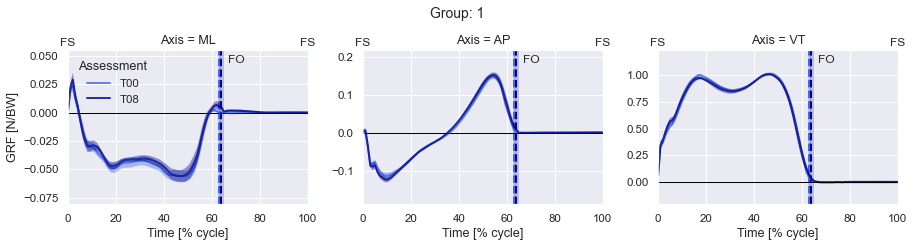

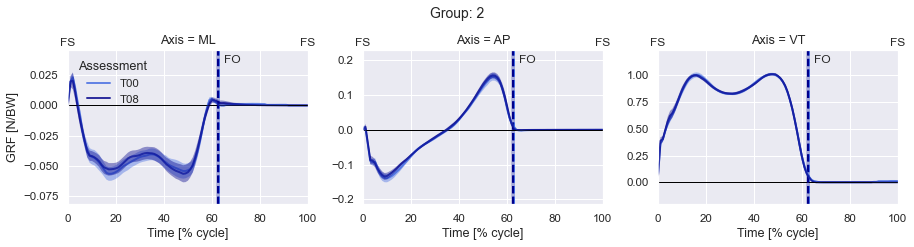

In [5]:
processa_plot(features, cycle='stride', variable='GRF') 

Creating DataArray for variable "Angle" cycle "stride"
Dimensions [time, var, axis, trial, subject, assessment, group]:
(101, 3, 3, 11, 20, 2, 2)



Number of trials, outlier trial, MSE, Variable, Axis, Subject, Assessment, Group
8 0 0.18524773849413556 Hip ML S04 T00 1
8 8 0.24728137987262658 Ankle ML S04 T00 1
8 8 0.2506700996107873 Hip AP S04 T00 1
7 4 0.48669747609568786 Hip ML S06 T00 1
7 4 0.4286313293693305 Hip AP S06 T00 1
7 3 0.24057346209410158 Knee ML S12 T00 1
6 7 0.5488669426108871 Hip ML S14 T00 1
6 7 0.47205108375330157 Knee ML S14 T00 1
6 1 0.3332181780311548 Ankle AP S14 T00 1
6 1 0.32396692996360005 Knee VT S14 T00 1
6 1 0.35188811036842943 Ankle VT S14 T00 1
9 2 0.2696173803561682 Ankle AP S15 T00 1
9 0 0.20389610689833024 Knee VT S15 T00 1
8 5 0.32442136104259933 Hip ML S04 T08 1
6 3 0.349616855272425 Hip ML S07 T08 1
9 2 0.20562403901061813 Hip VT S12 T08 1
6 7 0.3238590289824531 Hip ML S10 T00 2
6 4 0.4259779076041364 Hip ML S18 T00 2
6 4 0.2244902435143406 Knee ML S18 T00 2
6 8 0.4162688462748996 Ankle ML S18 T00 2
6 2 0.33608236341173037 Knee AP S18 T00 2
6 2 0.3136066183439818 Ankle VT S18 T00 2
9 5 0.1948

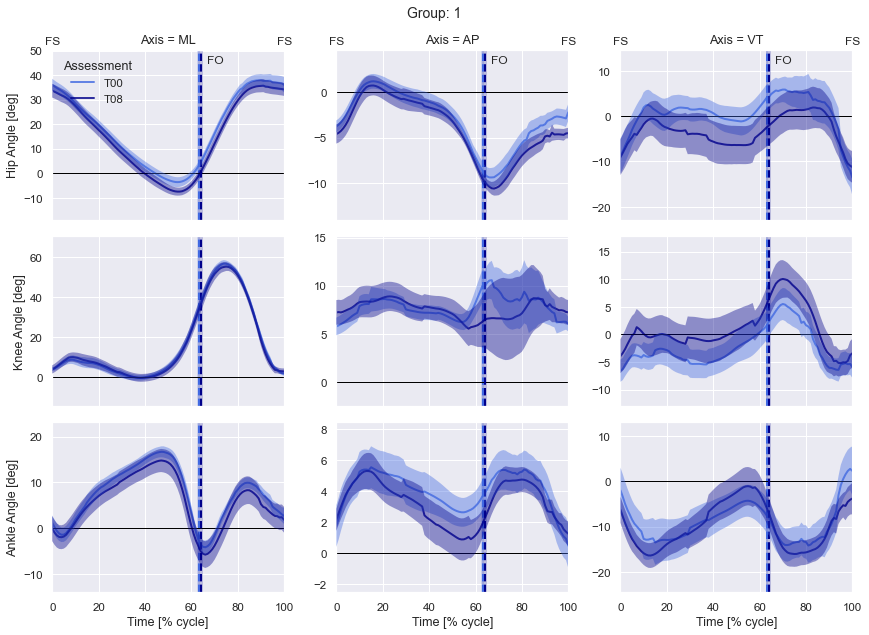

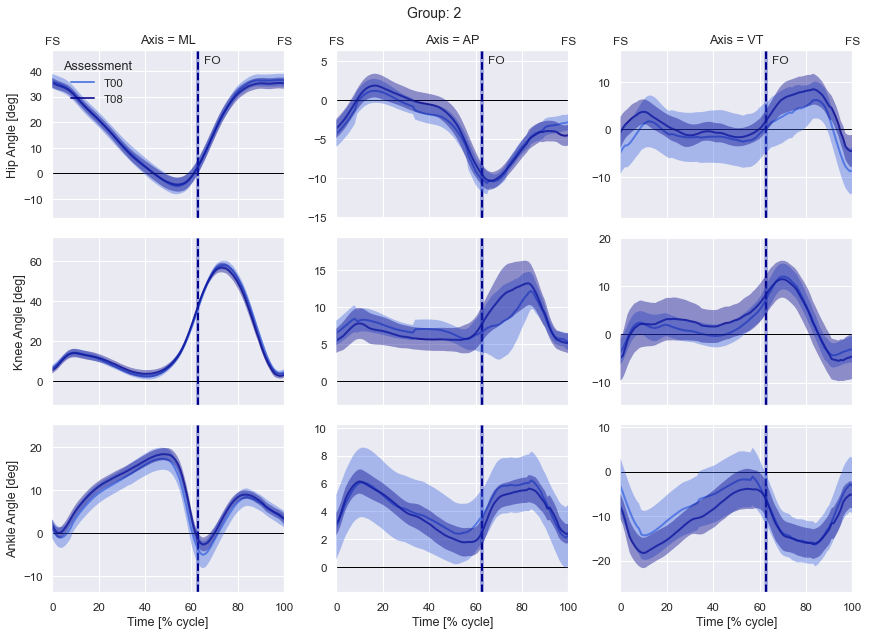

In [6]:
processa_plot(features, cycle='stride', variable='Angle') 

Creating DataArray for variable "Moment" cycle "stride"
Dimensions [time, var, axis, trial, subject, assessment, group]:
(101, 3, 3, 11, 20, 2, 2)



Number of trials, outlier trial, MSE, Variable, Axis, Subject, Assessment, Group
8 2 0.2206003081085727 Hip VT S04 T00 1
6 7 0.43654249082570956 Ankle ML S14 T00 1
7 3 0.3062697963149058 Ankle AP S16 T00 1
5 3 0.33954738214058455 Ankle AP S02 T08 1
8 5 0.27148961354286777 Hip ML S04 T08 1
8 5 0.42820614096956755 Knee ML S04 T08 1
8 5 0.33472124513992646 Ankle ML S04 T08 1
8 1 0.2674785154887203 Knee AP S04 T08 1
8 0 0.2743096424256228 Ankle AP S04 T08 1
8 5 0.37305850030808796 Hip VT S04 T08 1
8 7 0.32203565186579985 Knee VT S04 T08 1
7 1 0.4784531716644384 Ankle AP S07 T08 1
8 8 0.32423452257693225 Ankle AP S16 T08 1
8 6 0.2533421526275156 Ankle ML S08 T08 2
9 5 0.2632285855519181 Ankle AP S08 T08 2
9 9 0.16653074827701425 Hip ML S09 T08 2
9 9 0.24484089547788726 Knee ML S09 T08 2
9 4 0.22633711830610198 Ankle ML S09 T08 2
9 1 0.21439692554908865 Hip AP S09 T08 2
9 8 0.25804091528210615 Knee AP S09 T08 2
9 1 0.1787427470678521 Hip VT S09 T08 2
9 8 0.20587645492691317 Knee VT S09 T08 

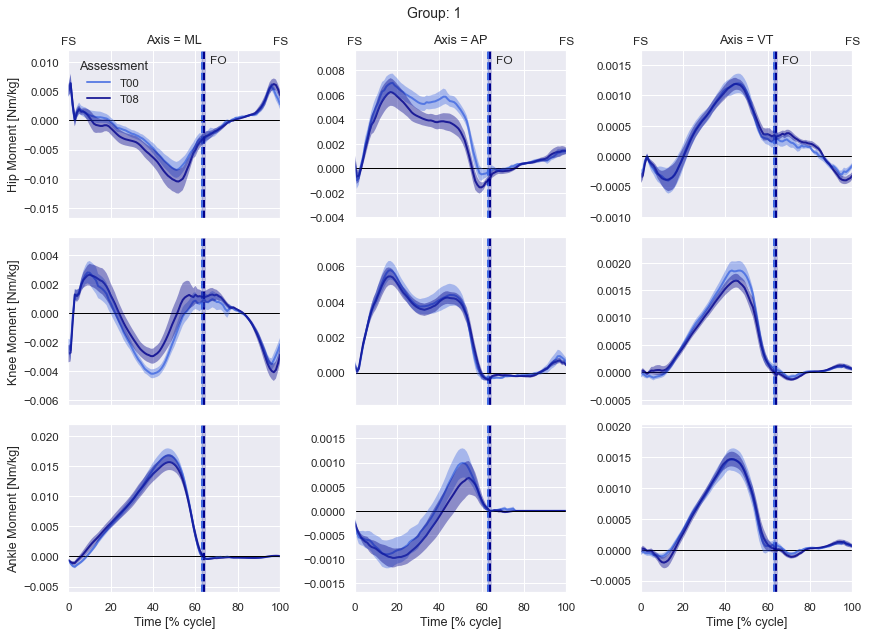

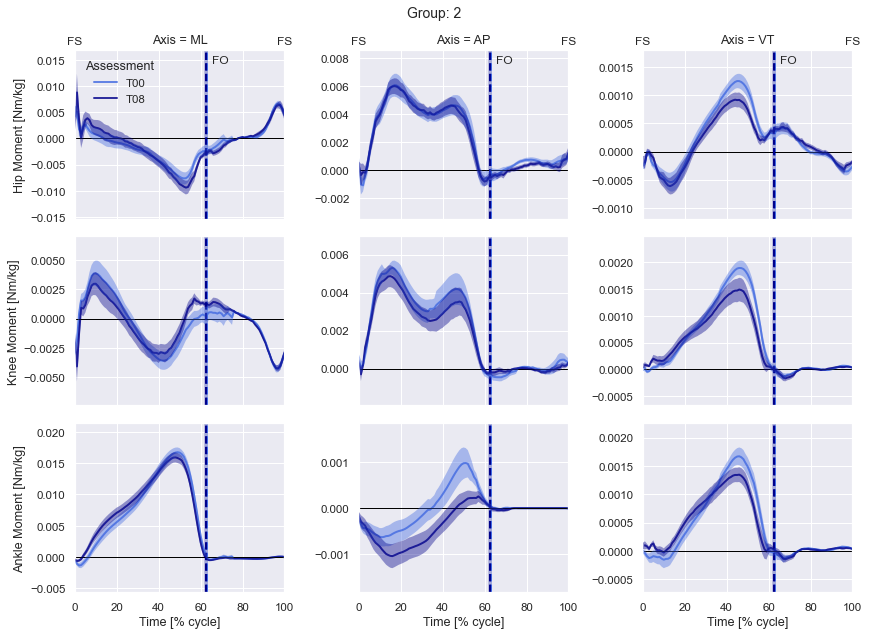

In [7]:
processa_plot(features, cycle='stride', variable='Moment') 

Creating DataArray for variable "Power" cycle "stride"
Dimensions [time, var, axis, trial, subject, assessment, group]:
(101, 3, 3, 11, 20, 2, 2)



Number of trials, outlier trial, MSE, Variable, Axis, Subject, Assessment, Group
8 1 0.4750425544378058 Knee VT S04 T00 1
8 9 0.35247969687474523 Ankle VT S04 T00 1
7 0 0.41775358764002224 Hip VT S06 T00 1
7 3 0.3917227753073514 Knee VT S12 T00 1
6 7 0.5344772266347025 Ankle VT S14 T00 1
9 9 0.31902646867839923 Knee VT S15 T00 1
8 5 0.2720909503374234 Hip VT S04 T08 1
8 5 0.3050382142444393 Knee VT S04 T08 1
8 1 0.21649703137945878 Knee VT S06 T08 1
6 5 0.47360886984975653 Ankle VT S07 T08 1
7 1 0.41940334931716733 Ankle VT S16 T08 1
9 6 0.277241436155878 Ankle VT S08 T08 2
9 4 0.20710671736933223 Hip VT S09 T08 2
9 4 0.30827395564140664 Knee VT S09 T08 2
9 4 0.24517022007518308 Ankle VT S09 T08 2
7 4 0.34723910311632794 Ankle VT S10 T08 2
9 5 0.30480808002047793 Hip VT S03 T08 2
9 1 0.3242235688599085 Hip VT S19 T08 2
9 6 0.2662860694002741 Ankle VT S19 T08 2
9 subjects
38 trials
8 subjects
38 trials
9 subjects
38 trials
9 subjects
45 trials


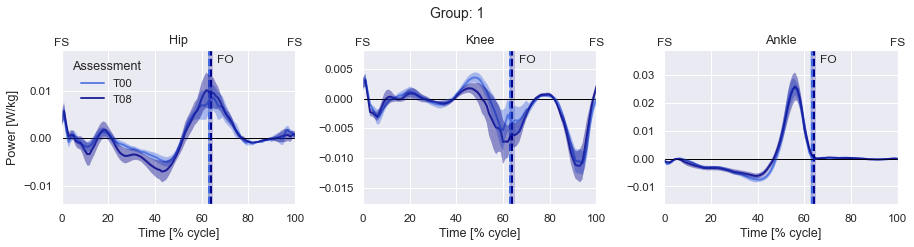

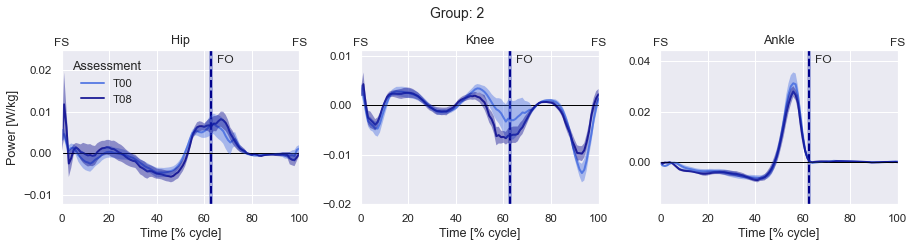

In [8]:
processa_plot(features, cycle='stride', variable='Power') 

Creating DataArray for variable "Oxford" cycle "stride"
Dimensions [time, var, axis, trial, subject, assessment, group]:
(101, 4, 3, 11, 20, 2, 2)



Number of trials, outlier trial, MSE, Variable, Axis, Subject, Assessment, Group
8 8 0.22365613881990024 FFTBA ML S04 T00 1
8 8 0.36616974048343764 HXFFA ML S04 T00 1
8 6 0.29616348822378624 FFHFA AP S04 T00 1
6 4 0.3087228676106428 HXFFA ML S06 T00 1
7 3 0.3467242866362319 HXFFA AP S06 T00 1
8 5 0.4527441085894485 FFHFA AP S04 T08 1
8 0 0.3207928844095254 HXFFA AP S04 T08 1
8 0 0.3018426457246561 HFTBA VT S04 T08 1
8 0 0.30131594199815487 FFHFA VT S04 T08 1
8 7 0.321917660260231 FFTBA VT S04 T08 1
6 2 0.5643859424073524 HXFFA VT S04 T08 1
5 8 0.4715932782916731 HXFFA ML S08 T00 2
9 6 0.19316385492618768 FFTBA ML S08 T08 2
9 1 0.342215401542721 FFHFA VT S08 T08 2
6 2 0.2881716443315571 FFTBA ML S13 T08 2
9 subjects
16 trials
8 subjects
30 trials
9 subjects
30 trials
9 subjects
61 trials


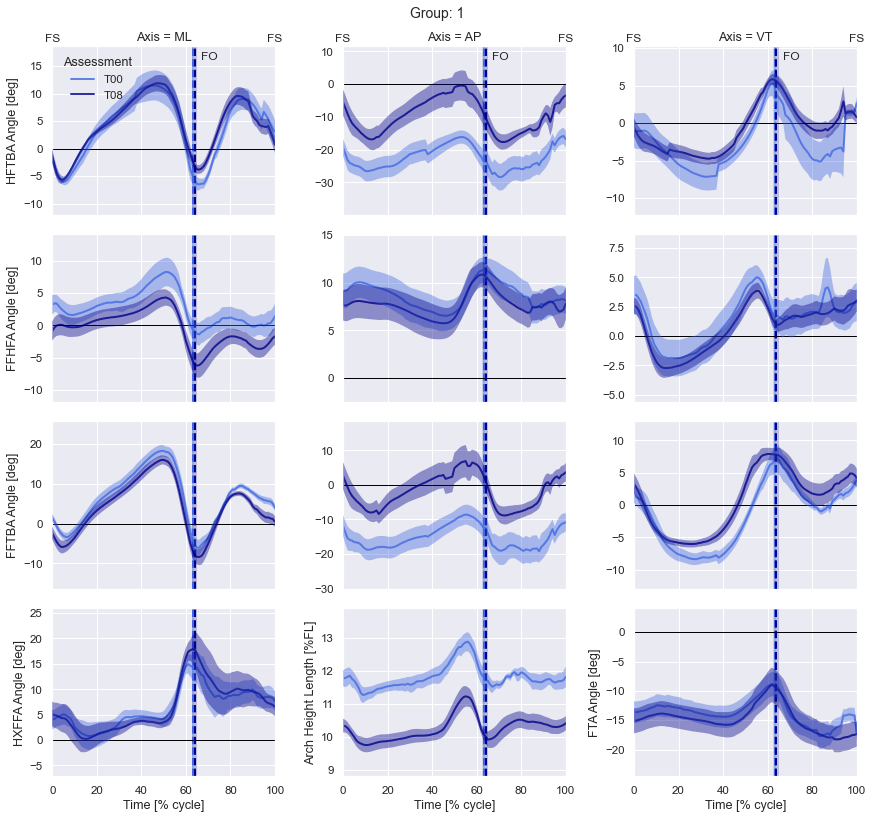

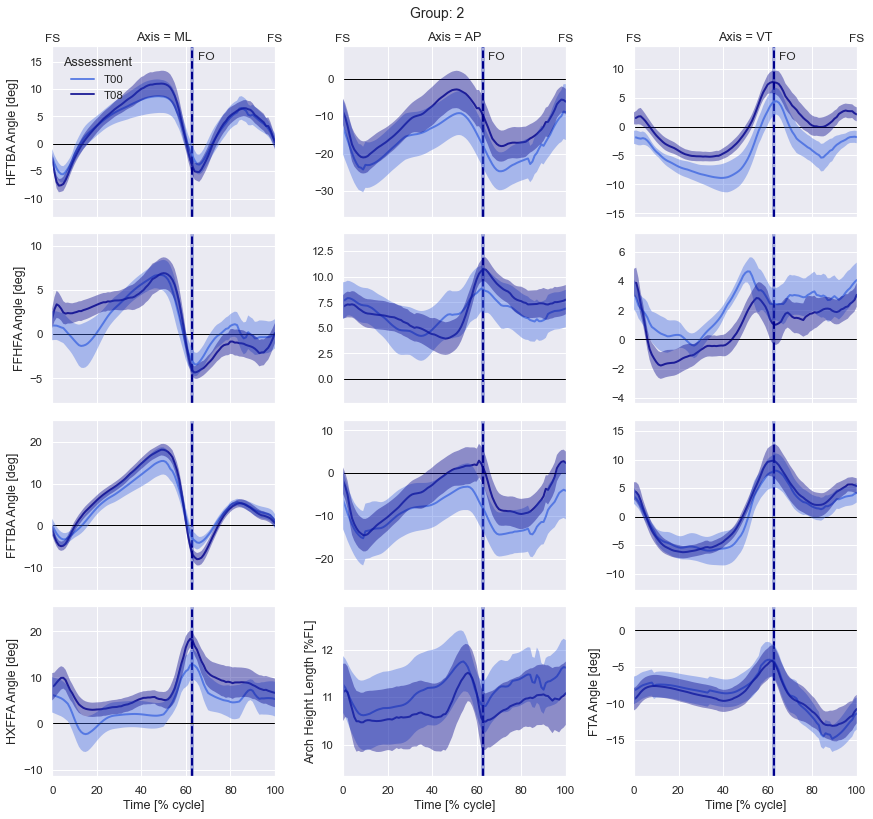

In [9]:
processa_plot(features, cycle='stride', variable='Oxford') 

Creating DataArray for variable "Oxford2" cycle "stride"
Dimensions [time, var, axis, trial, subject, assessment, group]:
(101, 3, 3, 11, 20, 2, 2)



Number of trials, outlier trial, MSE, Variable, Axis, Subject, Assessment, Group
8 8 0.36616974048343764 HXFFA ML S04 T00 1
7 8 0.23391402548566428 HXFFA AP S04 T00 1
8 6 0.29616348822378624 FFHFA AP S04 T00 1
6 4 0.3087228676106428 HXFFA ML S06 T00 1
7 2 0.32097845078942394 HXFFA AP S06 T00 1
8 0 0.32079288440952536 HXFFA AP S04 T08 1
8 5 0.4527441085894485 FFHFA AP S04 T08 1
6 2 0.5643859424073524 HXFFA VT S04 T08 1
8 0 0.30131594199815487 FFHFA VT S04 T08 1
8 0 0.3018426457246561 HFTBA VT S04 T08 1
5 8 0.4715932782916731 HXFFA ML S08 T00 2
9 1 0.342215401542721 FFHFA VT S08 T08 2
9 subjects
22 trials
8 subjects
52 trials
9 subjects
37 trials
9 subjects
74 trials


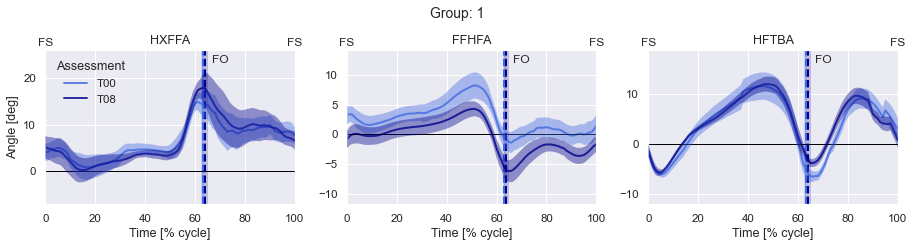

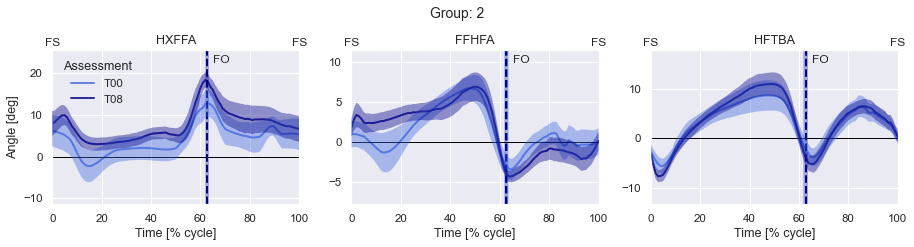

In [10]:
processa_plot(features, cycle='stride', variable='Oxford2') 

Creating DataArray for variable "GRF" cycle "stance"
Dimensions [time, var, axis, trial, subject, assessment, group]:
(101, 1, 3, 11, 20, 2, 2)



Number of trials, outlier trial, MSE, Variable, Axis, Subject, Assessment, Group
8 6 0.25593202658049263 Force1 VT S07 T00 1
5 1 0.3571497743851903 Force1 ML S02 T08 1
9 7 0.3214616645892373 Force1 AP S04 T08 1
9 2 0.4047308484059662 Force1 VT S04 T08 1
8 0 0.2265725620572081 Force1 ML S06 T08 1
8 8 0.28761924631625174 Force1 ML S11 T08 1
8 6 0.19729752027971897 Force1 AP S09 T00 2
8 0 0.2608067535938583 Force1 VT S09 T00 2
8 4 0.2546649058818064 Force1 AP S10 T08 2
8 4 0.3298557833586308 Force1 VT S10 T08 2
10 2 0.32454228825773174 Force1 VT S17 T08 2
9 subjects
82 trials
8 subjects
69 trials
9 subjects
78 trials
9 subjects
87 trials


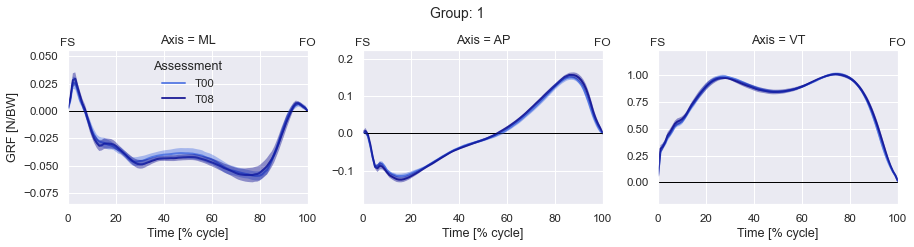

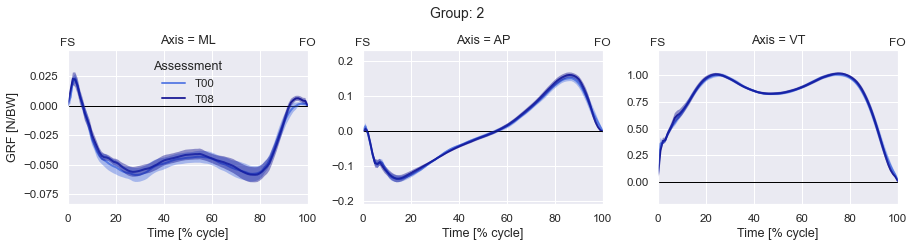

In [11]:
processa_plot(features, cycle='stance', variable='GRF') 

Creating DataArray for variable "Angle" cycle "stance"
Dimensions [time, var, axis, trial, subject, assessment, group]:
(101, 3, 3, 11, 20, 2, 2)



Number of trials, outlier trial, MSE, Variable, Axis, Subject, Assessment, Group
5 0 0.5221090934632096 Ankle AP S02 T00 1
5 0 0.5674331631625739 Ankle VT S02 T00 1
9 4 0.29225927120340706 Hip ML S04 T00 1
9 4 0.2559214251950749 Ankle ML S04 T00 1
9 2 0.37876728041983093 Hip AP S04 T00 1
8 4 0.4202615403700914 Hip ML S06 T00 1
8 4 0.4405010887651458 Hip AP S06 T00 1
8 6 0.39072432668271057 Hip ML S07 T00 1
8 6 0.3321175912277375 Knee ML S07 T00 1
8 0 0.2977270680793556 Knee VT S07 T00 1
9 1 0.3254910209319111 Hip AP S12 T00 1
9 8 0.19381541731629756 Knee AP S14 T00 1
9 6 0.3217657968635078 Ankle AP S14 T00 1
9 6 0.32751512631123075 Ankle VT S14 T00 1
5 2 0.26755981182062255 Knee AP S16 T00 1
9 4 0.3309107569357359 Hip ML S04 T08 1
9 1 0.17406483762682542 Knee ML S04 T08 1
8 6 0.2958984723376073 Ankle ML S06 T08 1
9 4 0.21595899763216597 Hip VT S12 T08 1
8 0 0.4044743103330512 Ankle ML S05 T00 2
8 6 0.31098388963037 Knee VT S08 T00 2
8 5 0.3686747738451487 Hip ML S09 T00 2
8 3 0.362997

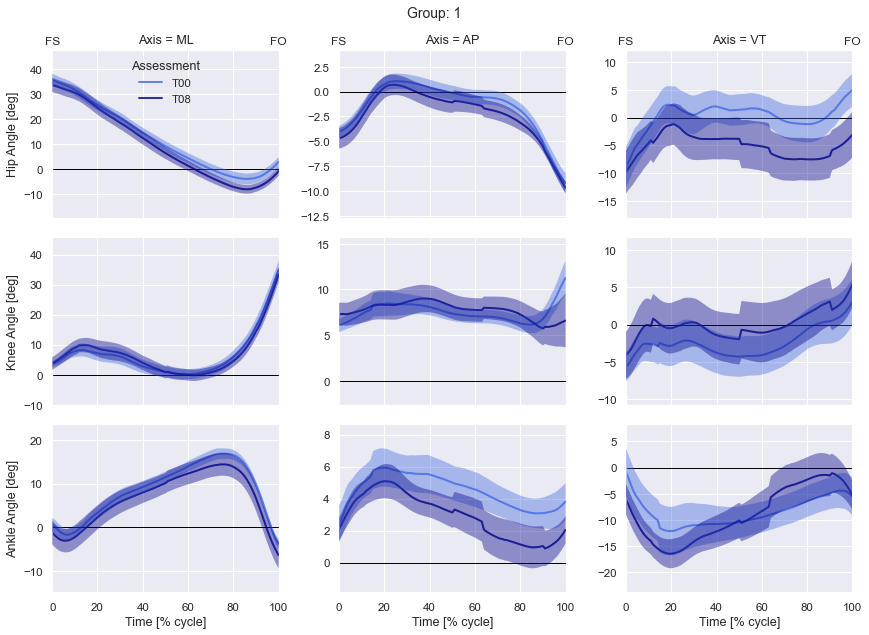

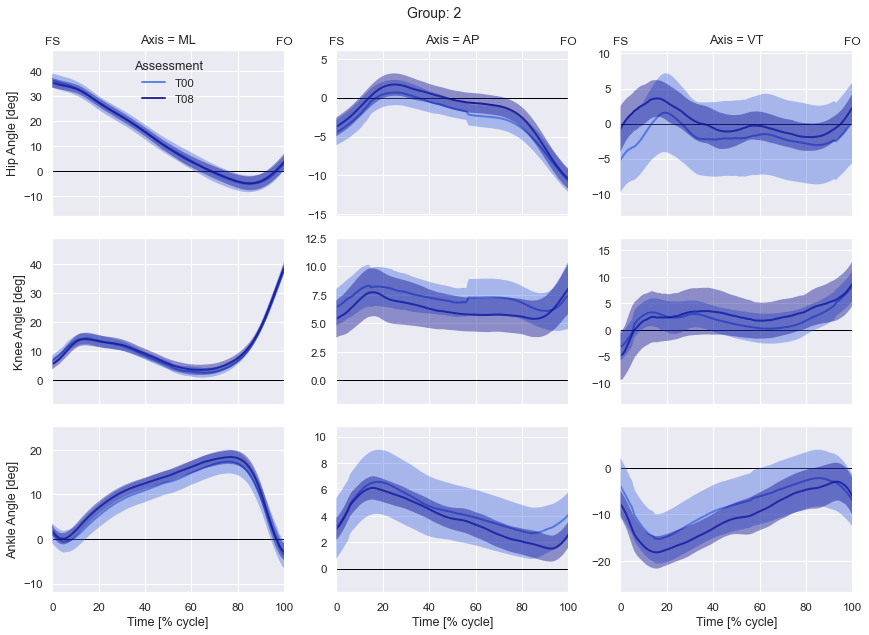

In [12]:
processa_plot(features, cycle='stance', variable='Angle') 

Creating DataArray for variable "Moment" cycle "stance"
Dimensions [time, var, axis, trial, subject, assessment, group]:
(101, 3, 3, 11, 20, 2, 2)



Number of trials, outlier trial, MSE, Variable, Axis, Subject, Assessment, Group
9 3 0.3229265318836639 Ankle ML S04 T00 1
9 4 0.20740826258967412 Knee AP S04 T00 1
9 9 0.22110205425093069 Hip VT S04 T00 1
8 3 0.24083530903026495 Ankle VT S04 T00 1
8 7 0.3619043804739158 Knee VT S07 T00 1
8 3 0.19355673047278033 Hip ML S11 T00 1
8 7 0.2698270096270926 Hip ML S12 T00 1
9 2 0.2348165325559045 Hip VT S12 T00 1
7 3 0.29364271940657366 Ankle AP S16 T00 1
5 4 0.34817996620419145 Ankle AP S02 T08 1
9 0 0.19529663183551563 Hip ML S04 T08 1
9 4 0.3361390682000435 Knee ML S04 T08 1
9 7 0.29620397286910993 Ankle ML S04 T08 1
9 2 0.399282383221481 Knee AP S04 T08 1
9 4 0.255484838199086 Hip VT S04 T08 1
9 7 0.31559289093714915 Knee VT S04 T08 1
9 8 0.201925009067262 Ankle VT S04 T08 1
7 1 0.5012878122169765 Ankle AP S07 T08 1
9 6 0.2798129395471153 Knee VT S12 T08 1
7 6 0.2462438421386543 Ankle ML S05 T00 2
8 5 0.23086327316968577 Hip ML S09 T00 2
8 7 0.31585932641569764 Ankle ML S09 T00 2
8 5 0.

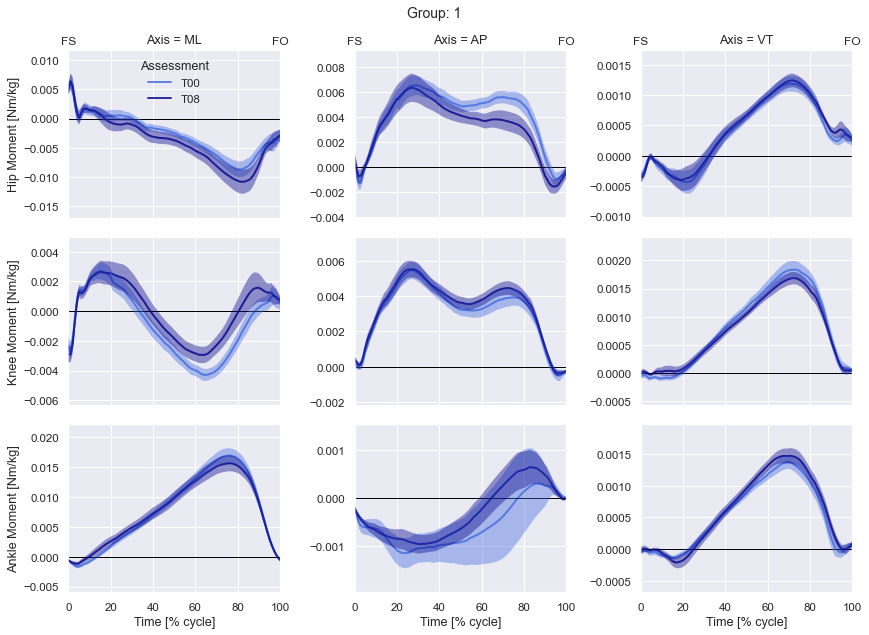

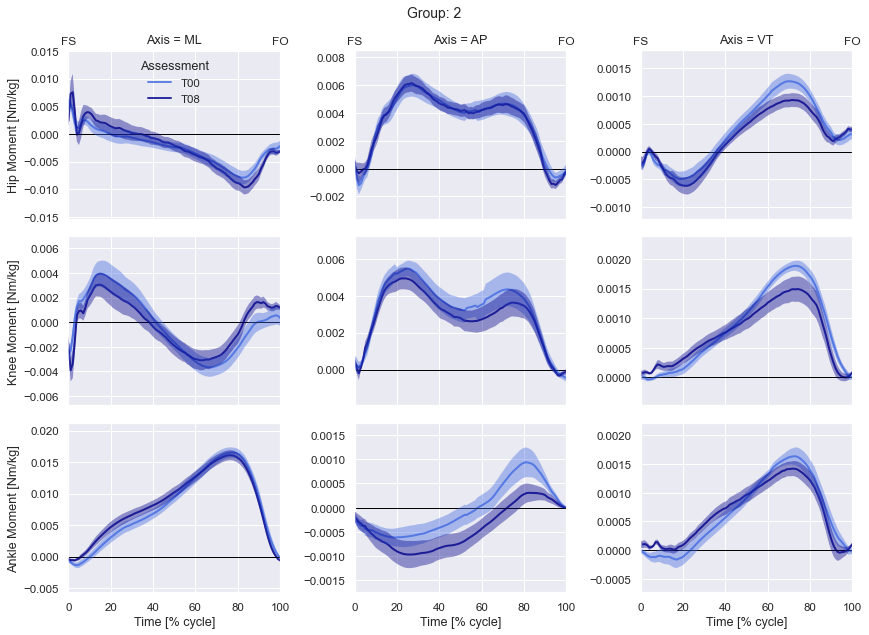

In [13]:
processa_plot(features, cycle='stance', variable='Moment') 

Creating DataArray for variable "Power" cycle "stance"
Dimensions [time, var, axis, trial, subject, assessment, group]:
(101, 3, 3, 11, 20, 2, 2)



Number of trials, outlier trial, MSE, Variable, Axis, Subject, Assessment, Group
6 2 0.3136439686172545 Knee VT S02 T00 1
8 9 0.26233339508521497 Knee VT S04 T00 1
8 7 0.38412140495643027 Ankle VT S04 T00 1
8 0 0.3853698929389975 Hip VT S06 T00 1
8 0 0.44196303561400013 Ankle VT S06 T00 1
8 6 0.26057694905355006 Hip VT S07 T00 1
8 5 0.2917788140260959 Knee VT S07 T00 1
8 1 0.3254168041042419 Ankle VT S07 T00 1
8 6 0.312272339385136 Hip VT S11 T00 1
8 4 0.2097957715274823 Knee VT S11 T00 1
9 2 0.17469530302934486 Hip VT S12 T00 1
9 5 0.2908256457080064 Knee VT S12 T00 1
9 4 0.20590877872087618 Hip VT S04 T08 1
9 4 0.37107221638797855 Knee VT S04 T08 1
8 5 0.2671012980966761 Ankle VT S04 T08 1
8 6 0.2785541380494557 Ankle VT S09 T00 2
7 1 0.34534136134909466 Hip VT S13 T00 2
7 1 0.37803662028882 Knee VT S13 T00 2
9 8 0.20968448233358322 Hip VT S09 T08 2
9 8 0.18515586521581892 Knee VT S09 T08 2
9 8 0.3359409011962787 Ankle VT S09 T08 2
10 2 0.22387768262830535 Ankle VT S17 T08 2
6 9 0.2

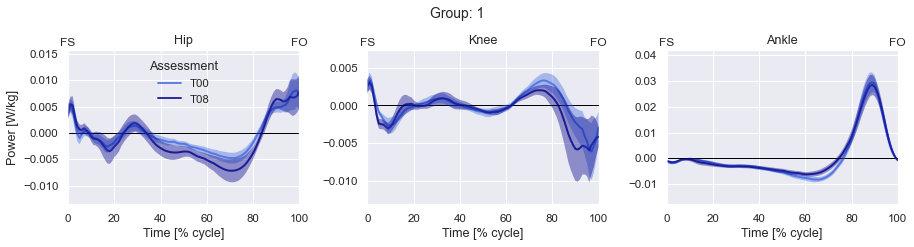

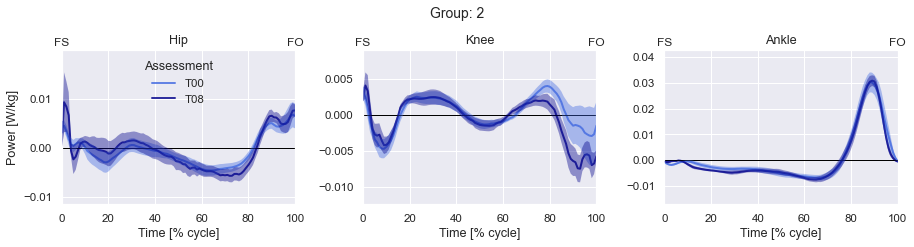

In [14]:
processa_plot(features, cycle='stance', variable='Power') 

Creating DataArray for variable "Oxford" cycle "stance"
Dimensions [time, var, axis, trial, subject, assessment, group]:
(101, 4, 3, 11, 20, 2, 2)



Number of trials, outlier trial, MSE, Variable, Axis, Subject, Assessment, Group
5 0 0.4483940247428683 HFTBA AP S02 T00 1
5 0 0.4881290090118025 FFTBA AP S02 T00 1
5 2 0.5275617036628105 HXFFA AP S02 T00 1
9 2 0.32829310092889075 FFHFA ML S04 T00 1
9 3 0.22576327258056694 FFTBA ML S04 T00 1
9 9 0.3951993483553795 HXFFA ML S04 T00 1
9 1 0.27729989548051603 FFHFA AP S04 T00 1
8 3 0.27939864156319033 HXFFA AP S04 T00 1
9 3 0.31681399149788925 HFTBA VT S04 T00 1
9 1 0.251992025972547 FFHFA VT S04 T00 1
8 0 0.3454409248479528 FFHFA ML S06 T00 1
8 2 0.3409113345305712 HXFFA AP S06 T00 1
8 3 0.3747674521968096 HXFFA VT S06 T00 1
8 1 0.28021342356566553 FFTBA ML S07 T00 1
8 1 0.36397062107593814 HXFFA VT S14 T00 1
7 1 0.2978064292119549 HXFFA VT S16 T00 1
9 0 0.2518934257447832 HXFFA AP S04 T08 1
9 0 0.19402017887500875 FFHFA VT S04 T08 1
9 4 0.29339762761325 FFTBA VT S04 T08 1
9 5 0.4412910949471635 HXFFA VT S04 T08 1
7 1 0.5484669766073363 HFTBA ML S06 T08 1
8 1 0.4527709199925821 FFTBA VT

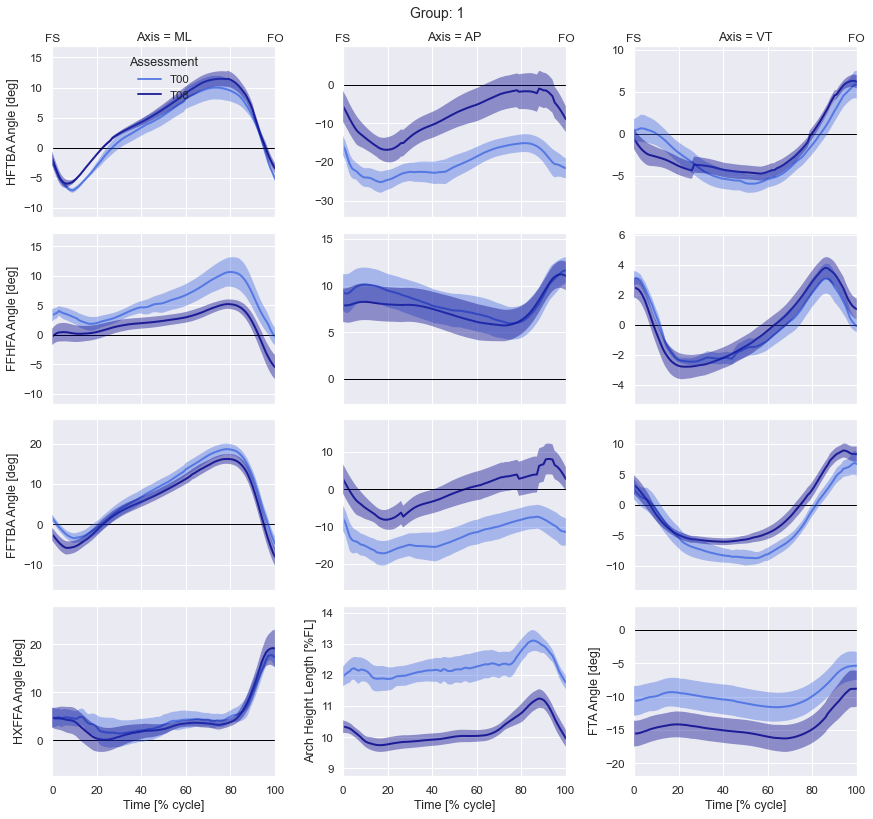

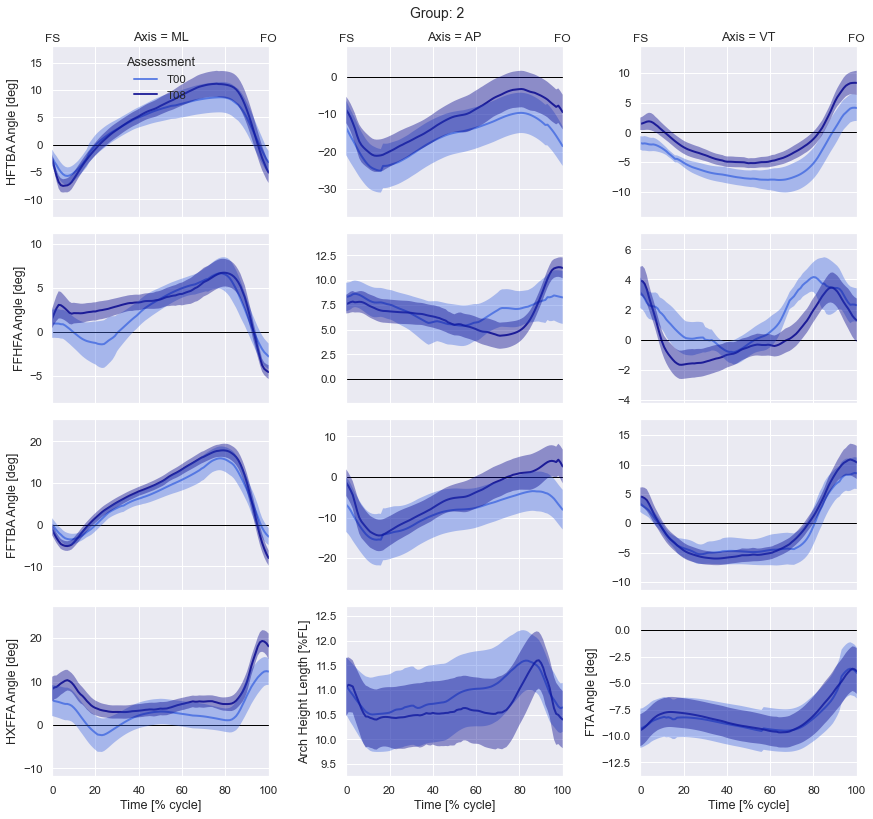

In [15]:
processa_plot(features, cycle='stance', variable='Oxford') 

Creating DataArray for variable "Oxford2" cycle "stance"
Dimensions [time, var, axis, trial, subject, assessment, group]:
(101, 3, 3, 11, 20, 2, 2)



Number of trials, outlier trial, MSE, Variable, Axis, Subject, Assessment, Group
5 0 0.4483940247428683 HFTBA AP S02 T00 1
9 9 0.3951993483553795 HXFFA ML S04 T00 1
9 2 0.32829310092889075 FFHFA ML S04 T00 1
8 3 0.23490014001055687 HXFFA AP S04 T00 1
9 1 0.27729989548051603 FFHFA AP S04 T00 1
9 1 0.251992025972547 FFHFA VT S04 T00 1
9 3 0.31681399149788925 HFTBA VT S04 T00 1
8 0 0.3454409248479528 FFHFA ML S06 T00 1
8 3 0.3201232382519721 HXFFA AP S06 T00 1
8 3 0.3747674521968096 HXFFA VT S06 T00 1
8 1 0.36397062107593814 HXFFA VT S14 T00 1
7 1 0.2978064292119549 HXFFA VT S16 T00 1
9 0 0.2518934257447832 HXFFA AP S04 T08 1
9 5 0.4412910949471635 HXFFA VT S04 T08 1
9 0 0.19402017887500875 FFHFA VT S04 T08 1
7 1 0.5484669766073363 HFTBA ML S06 T08 1
9 9 0.34252337369926733 HXFFA VT S12 T08 1
9 9 0.30576578141648986 HXFFA VT S16 T08 1
8 7 0.45489927572181493 HFTBA ML S05 T00 2
8 7 0.3313702665683727 HFTBA AP S05 T00 2
6 1 0.3924634556860892 HXFFA VT S05 T00 2
8 5 0.2938196373710287 HFTBA

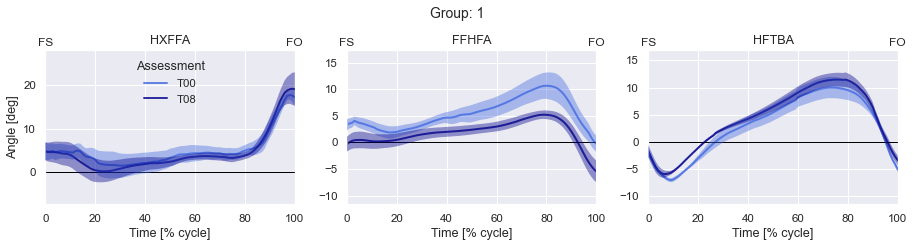

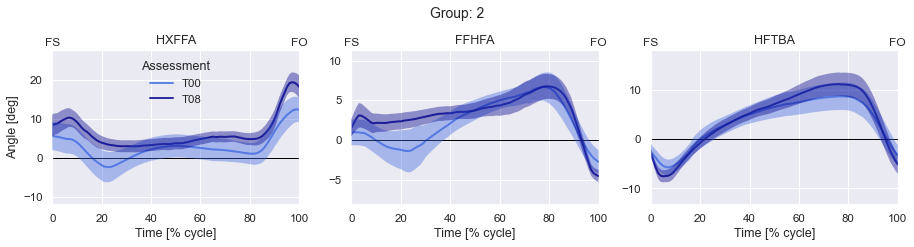

In [16]:
processa_plot(features, cycle='stance', variable='Oxford2') 